<a href="https://colab.research.google.com/github/raphaFanti/clothes-mnist-classification/blob/main/Image_classification_of_clothing_using_Neural_Network_on_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification of clothing
This is a personal implementation of the [tutorial](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l03c01_classifying_images_of_clothing.ipynb#scrollTo=P7mUJVqcINSM) on Udemy's Tensorflow course, with modifications and experimentations.

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Copyright 2018 The TensorFlow Authors.



In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Data acquisition

We will use here the [Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) which contains 70 thousand images (28 x 28 pixels) of clothing items, labeled in 10 categories (includes categories such as shirts and sandals).

It is available from TensorFlow's datasets directly. We will install the package and acquire the dataset, with the flags as_supervised (to get in format of tuples) and with_info to get the Metadata as well.

In [3]:
!pip3 install -U tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 30.9 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.6.0
    Uninstalling tensorflow-datasets-4.6.0:
      Successfully uninstalled tensorflow-datasets-4.6.0


In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf

ds, metadata = tfds.load("fashion_mnist", as_supervised = True, with_info = True)
print(ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteWH32E5/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteWH32E5/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
{Split('train'): <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [5]:
# get train and test sets
train_ds, test_ds = ds["train"], ds["test"]
assert isinstance(train_ds, tf.data.Dataset)

In [6]:
# get class names from metadata
class_names = metadata.features['label'].names
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Data preparation
Here we normalize the gray-scale values to floats between 0 and 1 (would be interesting to test other normalizations and compare) and enable caching to speed up execution (suggested in the original tutorial)

In [7]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images = images / 255
  return images, labels

train_ds = train_ds.map(normalize)
test_ds = test_ds.map(normalize)

train_ds =  train_ds.cache()
test_ds  =  test_ds.cache()

Now let's display some images to check the preceding steps.

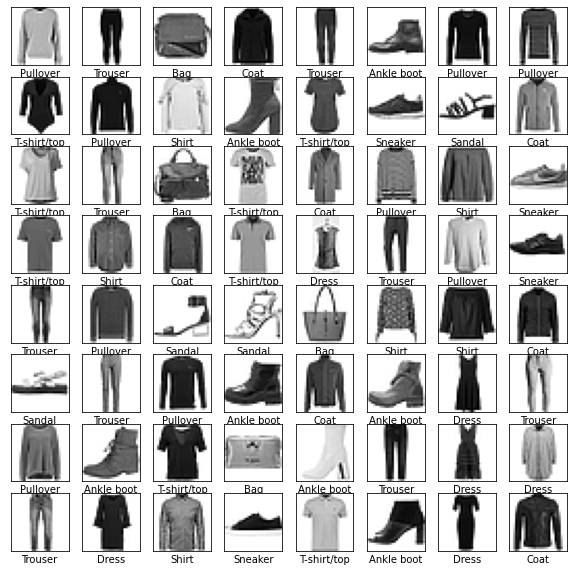

In [8]:
import matplotlib.pyplot as plt

grid_size = 8
samples = train_ds.take(grid_size ** 2)

plt.figure(figsize = (10, 10))
for i, (image, label) in enumerate(samples):
    image = image.numpy().reshape((28,28))
    plt.subplot(grid_size,grid_size,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])

plt.show()

As we can see the dataset is loaded and contains the right labels.

# A one layer dense model
We instantiate a model consisting of:


*   Flatten: transform the 28x28 images in a flat array
*   Hidden layer: a 128 neurons densly connected using reLU activation
*   Output: a densly connected 10 neurons layer with softmax (probabilities for each category)

We then compile the model with adam as optimizer, SparseCategoricalCrossentropy as loss function (has some issues apparently with the maxsoft approach for output) and accuracy as metric

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

Now let's define the training parameters:

*   We batch che images to feed to training
*   We shouffle the training dataset
*   We set it to repeat (epoch parameter will determine how many times the dataset will be used

In [15]:
import math

train_size = metadata.splits['train'].num_examples
test_size = metadata.splits['test'].num_examples
batch_size = 32 

train_ds = train_ds.cache().repeat().shuffle(train_size).batch(batch_size)
test_ds = test_ds.cache().batch(batch_size)

model.fit(train_ds, epochs = 5, steps_per_epoch = math.ceil(train_size/batch_size))

Epoch 1/5
1875/1875 [==============================] - 11s 3ms/step - loss: 0.4955 - accuracy: 0.8248
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3746 - accuracy: 0.8662
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3305 - accuracy: 0.8803
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3078 - accuracy: 0.8870
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2962 - accuracy: 0.8902


We get a 89% accuracy in the training dataset. Now let's check against unseen data

In [17]:
test_loss, test_accuracy = model.evaluate(test_ds, steps = math.ceil(test_size/batch_size))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.3415 - accuracy: 0.8759
Accuracy on test dataset: 0.8758999705314636


And here we get a slightely lower accuracy of 88%, still incredible for a model trained for less than a minute!

## Predictions
Let's run predictions on a batch and then on a single image. For the batch, it is enough that we ask to take one unit since the dataset is already batched.

In [26]:
import numpy as np

for test_images, test_labels in test_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

print("Predicion array for first image (probabilities for each category)")
print(predictions[0])
print("Label predicted: {}".format(class_names[np.argmax(predictions[0])]))
print("Actual label: {}".format(class_names[test_labels[0]]))

1/1 [==============================] - 0s 86ms/step
Predicion array for first image
[1.64242811e-05 4.83681288e-06 2.25394424e-02 2.90118146e-06
 9.54822481e-01 9.34669853e-09 2.24932414e-02 1.07423599e-08
 1.20658726e-04 6.75658696e-10]
Label predicted: Coat
Actual label: Coat


Now let's see more predictions to check for where the algorithm makes mistakes



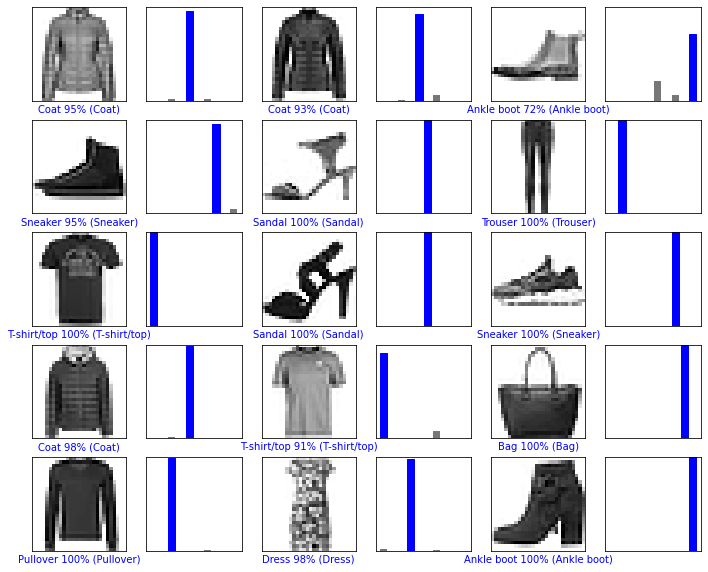

In [28]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


#make a grid with the display functions
num_cols = 3
num_rows = 5

num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

## Effect of epoch
Let's set epoch to 2 and check the accuracy


In [30]:
model.fit(train_ds, epochs = 1, steps_per_epoch = math.ceil(train_size/batch_size))
test_loss, test_accuracy = model.evaluate(test_ds, steps = math.ceil(test_size/batch_size))
print('Accuracy with 1 epoch:', test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.3440 - accuracy: 0.8778
Accuracy with 1 epoch: 0.8777999877929688


As we can see there's little effect of the amount of epochs in this situation, improving the accuracy of only 1% in 4 additional epochs

## Changing the amount of neurons in hidden layer
Now let's change the number of neurons in the mid layer to see the effect in accuracy

In [34]:
neurons = np.linspace(10, 512, 30, dtype = int)
accuracies = []
for n in neurons:
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
    tf.keras.layers.Dense(n, activation = tf.nn.relu),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
    ])

  model.compile(optimizer = 'adam',
                loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics = ['accuracy'])
  model.fit(train_ds, epochs = 1, steps_per_epoch = math.ceil(train_size/batch_size))
  test_loss, test_accuracy = model.evaluate(test_ds, steps = math.ceil(test_size/batch_size))
  accuracies.append(test_accuracy)

print(accuracies)

313/313 [==============================] - 1s 2ms/step - loss: 0.4017 - accuracy: 0.8534
[0.8184000253677368, 0.8389000296592712, 0.8384000062942505, 0.8379999995231628, 0.8454999923706055, 0.840399980545044, 0.8507999777793884, 0.8464000225067139, 0.8464000225067139, 0.8531000018119812, 0.8180999755859375, 0.8555999994277954, 0.8267999887466431, 0.835099995136261, 0.8549000024795532, 0.8529999852180481, 0.8436999917030334, 0.8554999828338623, 0.8525000214576721, 0.8409000039100647, 0.8352000117301941, 0.8536999821662903, 0.8489000201225281, 0.8598999977111816, 0.8514999747276306, 0.8539000153541565, 0.8503000140190125, 0.8543999791145325, 0.845300018787384, 0.8533999919891357]


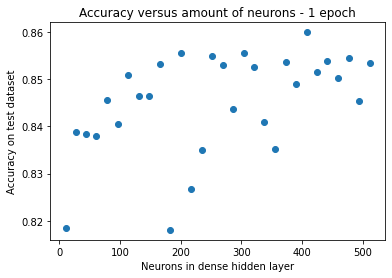

In [39]:
plt.figure()
plt.scatter(neurons, accuracies)
plt.title("Accuracy versus amount of neurons - 1 epoch")
plt.xlabel("Neurons in dense hidden layer")
plt.ylabel("Accuracy on test dataset")
plt.show()

We can see from the scattered data that the curve seems assyntotic to a limit of around 86%, regardless of the amount of neurons used.

The curve seems to flatten at around 150 neurons, now we understand the initial proposal of 128 (no, it was not magic!).

## Adding a layer
Now let's see what we get from adding another dense layer to the network. Let's use the same amount of neurons.

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
    ])

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])
model.fit(train_ds, epochs = 5, steps_per_epoch = math.ceil(train_size/batch_size))
test_loss, test_accuracy = model.evaluate(test_ds, steps = math.ceil(test_size/batch_size))
print("Accuracy of model with 2 hidden layers: {}".format(test_accuracy))

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4832 - accuracy: 0.8250
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3635 - accuracy: 0.8668
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3241 - accuracy: 0.8804
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3033 - accuracy: 0.8860
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.8689
Accuracy of model with 2 hidden layers: 0.8689000010490417


Here we can see that by adding another layer of neurons we have not been able to improve accuracy, we actually reduced it!

# A Convolutional network